# Preliminaries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.manifold import TSNE

from scipy.interpolate import interp1d
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,  davies_bouldin_score
from scipy.spatial.distance import cdist
from kneed import KneeLocator

from tqdm import tqdm

In [2]:
# ! pip install kneed

In [3]:
# ! pip install yellowbrick

# Data Preprocessing

In [4]:
df = pd.read_csv('C:/Users/MANCY036/Downloads/Eskwelabs/consolidated_csv_03AVION_U01.csv')
df.head()

,RUN_TIME,MKT_TYPE,REGION_NAME,ZONE_NAME,RESOURCE_NAME,TIME_INTERVAL,START_TIME,END_TIME,MP_NAME,PRICE1,...,RR_BREAK_QUANTITY3,RR_UP3,RR_DOWN3,RR_BREAK_QUANTITY4,RR_UP4,RR_DOWN4,RR_BREAK_QUANTITY5,RR_UP5,RR_DOWN5,Unnamed: 46
0,06/26/2021,RTD,CLUZ,SLUZON,03AVION_U01,06/26/2021 12:05:00 AM,06/26/2021,06/26/2021 12:05:00 AM,PMPC,-999.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06/26/2021 12:05:00 AM,RTD,CLUZ,SLUZON,03AVION_U01,06/26/2021 12:10:00 AM,06/26/2021 12:05:00 AM,06/26/2021 12:10:00 AM,PMPC,-999.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06/26/2021 12:10:00 AM,RTD,CLUZ,SLUZON,03AVION_U01,06/26/2021 12:15:00 AM,06/26/2021 12:10:00 AM,06/26/2021 12:15:00 AM,PMPC,-999.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,06/26/2021 12:15:00 AM,RTD,CLUZ,SLUZON,03AVION_U01,06/26/2021 12:20:00 AM,06/26/2021 12:15:00 AM,06/26/2021 12:20:00 AM,PMPC,-999.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,06/26/2021 12:20:00 AM,RTD,CLUZ,SLUZON,03AVION_U01,06/26/2021 12:25:00 AM,06/26/2021 12:20:00 AM,06/26/2021 12:25:00 AM,PMPC,-999.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Dropping of columns

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202144 entries, 0 to 202143
Data columns (total 47 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   RUN_TIME            202144 non-null  object 
 1   MKT_TYPE            202144 non-null  object 
 2   REGION_NAME         202144 non-null  object 
 3   ZONE_NAME           202144 non-null  object 
 4   RESOURCE_NAME       202144 non-null  object 
 5   TIME_INTERVAL       202144 non-null  object 
 6   START_TIME          202144 non-null  object 
 7   END_TIME            202144 non-null  object 
 8   MP_NAME             197835 non-null  object 
 9   PRICE1              202144 non-null  float64
 10  QUANTITY1           202144 non-null  float64
 11  PRICE2              202144 non-null  float64
 12  QUANTITY2           202144 non-null  float64
 13  PRICE3              196197 non-null  float64
 14  QUANTITY3           196197 non-null  float64
 15  PRICE4              119 non-null  

In [6]:
# Define the columns containing price-quantity pairs and timestamps
price_columns = [f'PRICE{i}' for i in range(1, 12)]
quantity_columns = [f'QUANTITY{i}' for i in range(1, 12)]

# Corrected line with tuple comprehension
selected_columns = ['RUN_TIME'] + [price for price in price_columns] + [quantity for quantity in quantity_columns]

In [7]:
# Apply the selection to the filtered DataFrame
result_df = df[selected_columns]
result_df

,RUN_TIME,PRICE1,PRICE2,PRICE3,PRICE4,PRICE5,PRICE6,PRICE7,PRICE8,PRICE9,...,QUANTITY2,QUANTITY3,QUANTITY4,QUANTITY5,QUANTITY6,QUANTITY7,QUANTITY8,QUANTITY9,QUANTITY10,QUANTITY11
0,06/26/2021,-999.0,-999.0,3044.36,NaN,NaN,NaN,NaN,NaN,NaN,...,23.0,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06/26/2021 12:05:00 AM,-999.0,-999.0,3044.36,NaN,NaN,NaN,NaN,NaN,NaN,...,23.0,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06/26/2021 12:10:00 AM,-999.0,-999.0,3044.36,NaN,NaN,NaN,NaN,NaN,NaN,...,23.0,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,06/26/2021 12:15:00 AM,-999.0,-999.0,3044.36,NaN,NaN,NaN,NaN,NaN,NaN,...,23.0,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,06/26/2021 12:20:00 AM,-999.0,-999.0,3044.36,NaN,NaN,NaN,NaN,NaN,NaN,...,23.0,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202139,09/25/2023 11:35:00 PM,-999.0,-999.0,4411.24,NaN,NaN,NaN,NaN,NaN,NaN,...,23.0,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202140,09/25/2023 11:40:00 PM,-999.0,-999.0,4411.24,NaN,NaN,NaN,NaN,NaN,NaN,...,23.0,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202141,09/25/2023 11:45:00 PM,-999.0,-999.0,4411.24,NaN,NaN,NaN,NaN,NaN,NaN,...,23.0,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202142,09/25/2023 11:50:00 PM,-999.0,-999.0,4411.24,NaN,NaN,NaN,NaN,NaN,NaN,...,23.0,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df[selected_columns].describe()

,PRICE1,PRICE2,PRICE3,PRICE4,PRICE5,PRICE6,PRICE7,PRICE8,PRICE9,PRICE10,...,QUANTITY2,QUANTITY3,QUANTITY4,QUANTITY5,QUANTITY6,QUANTITY7,QUANTITY8,QUANTITY9,QUANTITY10,QUANTITY11
count,202144.000000,202144.000000,196197.000000,119.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,202144.000000,196197.000000,119.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,-218.801512,-218.801512,6920.875917,6021.013445,NaN,NaN,NaN,NaN,NaN,NaN,...,24.844081,43.219697,46.877311,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4269.485275,4269.485275,3337.981012,6532.630849,NaN,NaN,NaN,NaN,NaN,NaN,...,6.417319,1.006727,0.967649,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-10000.000000,-10000.000000,0.000000,3863.700000,NaN,NaN,NaN,NaN,NaN,NaN,...,3.000000,20.000000,44.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,-999.000000,-999.000000,4504.640000,3863.700000,NaN,NaN,NaN,NaN,NaN,NaN,...,23.000000,43.000000,47.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,-999.000000,-999.000000,5929.360000,4583.150000,NaN,NaN,NaN,NaN,NaN,NaN,...,23.000000,43.000000,47.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,-999.000000,-999.000000,7556.450000,4617.020000,NaN,NaN,NaN,NaN,NaN,NaN,...,23.000000,43.000000,47.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,29000.000000,29000.000000,29000.000000,32000.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,47.200000,47.200000,47.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#change Uppercase to lowercase
result_df.columns = result_df.columns.str.lower()

## FFill NaNs with last Price-Quantity Bid

In [10]:
# Forward fill from the first non-null value in each row for the price columns
result_df.loc[:, 'price1':'price11'] = result_df.loc[:, 'price1':'price11'].apply(lambda row: row.ffill(), axis=1)

# Forward fill from the first non-null value in each row for the quantity columns
result_df.loc[:, 'quantity1':'quantity11'] = result_df.loc[:, 'quantity1':'quantity11'].apply(lambda row: row.ffill(), axis=1)

## TAKES 30 SECONDS TO RUN
result_df

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,...,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
0,06/26/2021,-999.0,-999.0,3044.36,3044.36,3044.36,3044.36,3044.36,3044.36,3044.36,...,23.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0
1,06/26/2021 12:05:00 AM,-999.0,-999.0,3044.36,3044.36,3044.36,3044.36,3044.36,3044.36,3044.36,...,23.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0
2,06/26/2021 12:10:00 AM,-999.0,-999.0,3044.36,3044.36,3044.36,3044.36,3044.36,3044.36,3044.36,...,23.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0
3,06/26/2021 12:15:00 AM,-999.0,-999.0,3044.36,3044.36,3044.36,3044.36,3044.36,3044.36,3044.36,...,23.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0
4,06/26/2021 12:20:00 AM,-999.0,-999.0,3044.36,3044.36,3044.36,3044.36,3044.36,3044.36,3044.36,...,23.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202139,09/25/2023 11:35:00 PM,-999.0,-999.0,4411.24,4411.24,4411.24,4411.24,4411.24,4411.24,4411.24,...,23.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0
202140,09/25/2023 11:40:00 PM,-999.0,-999.0,4411.24,4411.24,4411.24,4411.24,4411.24,4411.24,4411.24,...,23.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0
202141,09/25/2023 11:45:00 PM,-999.0,-999.0,4411.24,4411.24,4411.24,4411.24,4411.24,4411.24,4411.24,...,23.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0
202142,09/25/2023 11:50:00 PM,-999.0,-999.0,4411.24,4411.24,4411.24,4411.24,4411.24,4411.24,4411.24,...,23.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0,43.0


## Filter to 2022 data

In [11]:
result_df['run_time'] = result_df['run_time'].astype(str)

C:\Users\MANCY036\AppData\Local\Temp\ipykernel_8660\2012798107.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['run_time'] = result_df['run_time'].astype(str)


In [12]:
#df_2022 = result_df[result_df['run_time'].str[6:10]=='2022']
df_2022 = result_df[result_df['run_time'].str.contains('2022')]
df_2022.head()

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,...,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
45175,02/06/2022 07:15:00 PM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0
45176,02/06/2022 07:20:00 PM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0
45177,02/06/2022 08:50:00 PM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0
45178,02/06/2022 08:55:00 PM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0
45179,02/06/2022 09:00:00 PM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0,45.0


In [13]:
df_2022.describe()

,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,...,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
count,84652.000000,84652.000000,84652.000000,84652.000000,84652.000000,84652.000000,84652.000000,84652.000000,84652.000000,84652.000000,...,84652.000000,84652.000000,84652.000000,84652.000000,84652.000000,84652.000000,84652.000000,84652.000000,84652.000000,84652.000000
mean,140.268514,140.268514,7514.525806,7517.187996,7517.187996,7517.187996,7517.187996,7517.187996,7517.187996,7517.187996,...,26.519467,43.570815,43.575086,43.575086,43.575086,43.575086,43.575086,43.575086,43.575086,43.575086
std,5002.094946,5002.094946,4669.162514,4673.955651,4673.955651,4673.955651,4673.955651,4673.955651,4673.955651,4673.955651,...,8.501710,1.537520,1.533428,1.533428,1.533428,1.533428,1.533428,1.533428,1.533428,1.533428
min,-9999.000000,-9999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
25%,-999.000000,-999.000000,5104.700000,5104.700000,5104.700000,5104.700000,5104.700000,5104.700000,5104.700000,5104.700000,...,23.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000
50%,-999.000000,-999.000000,5855.550000,5855.550000,5855.550000,5855.550000,5855.550000,5855.550000,5855.550000,5855.550000,...,23.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000
75%,-999.000000,-999.000000,7447.360000,7447.360000,7447.360000,7447.360000,7447.360000,7447.360000,7447.360000,7447.360000,...,23.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000
max,29000.000000,29000.000000,29000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,...,47.200000,47.200000,47.200000,47.200000,47.200000,47.200000,47.200000,47.200000,47.200000,47.200000


## Normalize quantity values

In [14]:
from sklearn.preprocessing import MinMaxScaler

# Extract only the quantity columns for normalization
quantity_columns = [f'quantity{i}' for i in range(1, 12)]

# Flatten the DataFrame and extract only quantity columns
flattened_quantities = df_2022[quantity_columns].values.flatten()

# Reshape the flattened quantities to a column vector
flattened_quantities = flattened_quantities.reshape(-1, 1)

# Use MinMaxScaler on the flattened quantities
scaler = MinMaxScaler()
scaled_quantities = scaler.fit_transform(flattened_quantities)

# Reshape the scaled quantities to match the original DataFrame shape
scaled_quantities = scaled_quantities.reshape(df_2022[quantity_columns].shape)

# Update the DataFrame with the scaled values
df_2022.loc[:, quantity_columns] = scaled_quantities

In [15]:
df_2022.head()

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,...,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
45175,02/06/2022 07:15:00 PM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339
45176,02/06/2022 07:20:00 PM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339
45177,02/06/2022 08:50:00 PM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339
45178,02/06/2022 08:55:00 PM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339
45179,02/06/2022 09:00:00 PM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339


In [16]:
df_2022.describe()

,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,...,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
count,84652.000000,84652.000000,84652.000000,84652.000000,84652.000000,84652.000000,84652.000000,84652.000000,84652.000000,84652.000000,...,84652.000000,84652.000000,84652.000000,84652.000000,84652.000000,84652.000000,84652.000000,84652.000000,84652.000000,84652.000000
mean,140.268514,140.268514,7514.525806,7517.187996,7517.187996,7517.187996,7517.187996,7517.187996,7517.187996,7517.187996,...,0.561853,0.923110,0.923201,0.923201,0.923201,0.923201,0.923201,0.923201,0.923201,0.923201
std,5002.094946,5002.094946,4669.162514,4673.955651,4673.955651,4673.955651,4673.955651,4673.955651,4673.955651,4673.955651,...,0.180121,0.032575,0.032488,0.032488,0.032488,0.032488,0.032488,0.032488,0.032488,0.032488
min,-9999.000000,-9999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.063559,0.423729,0.423729,0.423729,0.423729,0.423729,0.423729,0.423729,0.423729,0.423729
25%,-999.000000,-999.000000,5104.700000,5104.700000,5104.700000,5104.700000,5104.700000,5104.700000,5104.700000,5104.700000,...,0.487288,0.911017,0.911017,0.911017,0.911017,0.911017,0.911017,0.911017,0.911017,0.911017
50%,-999.000000,-999.000000,5855.550000,5855.550000,5855.550000,5855.550000,5855.550000,5855.550000,5855.550000,5855.550000,...,0.487288,0.911017,0.911017,0.911017,0.911017,0.911017,0.911017,0.911017,0.911017,0.911017
75%,-999.000000,-999.000000,7447.360000,7447.360000,7447.360000,7447.360000,7447.360000,7447.360000,7447.360000,7447.360000,...,0.487288,0.911017,0.911017,0.911017,0.911017,0.911017,0.911017,0.911017,0.911017,0.911017
max,29000.000000,29000.000000,29000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,32000.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Obtain bidding curve and price series for clustering

In [17]:
# Assuming df is your DataFrame with price-quantity pairs in each row
test_df = df_2022#.iloc[:10000]

# Create empty lists to store data for all stepwise curves
all_quantities = []
all_prices = []
all_intp_quantities = []
all_intp_prices = []

# Iterate through each row
for index, row in tqdm(test_df.iterrows(), total=len(test_df), desc='Processing rows'):
    # Extract price and quantity columns for the current row
    prices = row.filter(like='price')
    quantities = row.filter(like='quantity')

    # Sort data by quantity
    sorted_data = sorted(zip(quantities, prices))
    quantities, prices = zip(*sorted_data)

    # Interpolate prices for regular quantity intervals
    step_fx = interp1d(quantities, prices, kind='next', fill_value='extrapolate')
    step = df_2022['quantity11'].max() / 10

    # Create a finer quantity range for interpolation
    intp_quantities = np.arange(df_2022['quantity1'].min(), df_2022['quantity11'].max() + 0.1, step)
    
    # Get interpolated prices
    intp_prices = step_fx(intp_quantities)
    
    # Set a condition to handle quantities beyond the maximum in the raw data
    max_quantity_interval = max(quantities)
    intp_prices[intp_quantities > max_quantity_interval] = 33000
    
    # Append data to lists
    all_quantities.append(quantities)
    all_prices.append(prices)
    all_intp_quantities.append(intp_quantities)
    all_intp_prices.append(intp_prices)

Processing rows: 100%|██████████| 84652/84652 [03:00<00:00, 468.39it/s]


In [18]:
# Convert the interpolated prices into price series
price_series = np.array(all_intp_prices)
price_series

array([[    0.  ,     0.  ,     0.  , ...,     0.  ,     0.  , 33000.  ],
       [    0.  ,     0.  ,     0.  , ...,     0.  ,     0.  , 33000.  ],
       [    0.  ,     0.  ,     0.  , ...,     0.  ,     0.  , 33000.  ],
       ...,
       [ -999.  ,  -999.  ,  -999.  , ...,  5043.54,  5043.54, 33000.  ],
       [ -999.  ,  -999.  ,  -999.  , ...,  5043.54,  5043.54, 33000.  ],
       [ -999.  ,  -999.  ,  -999.  , ...,  5043.54,  5043.54, 33000.  ]])

In [19]:
# # Export price series to a new graph - remember to change the powerplant name

# # Specify the CSV file path
# csv_file_path = 'C:\\Users\\berna\\maroon-archers\\consolidated_csv_03AVION_U01_price_series.csv'

# # Save the array to a CSV file
# np.savetxt(csv_file_path, price_series, delimiter=',')

# print(f"Array has been saved to {csv_file_path}")

In [20]:
# # Plot all stepwise curves on a single graph
# plt.figure(figsize=(10, 6))

# for quantities, prices, intp_quantities, intp_prices in tqdm(zip(all_quantities, all_prices, all_intp_quantities, all_intp_prices), total=len(all_quantities), desc='Processing'):
#     plt.step(quantities, prices, where='pre')
#     plt.scatter(intp_quantities, intp_prices, color='red')

# # Customize the plot as needed
# plt.xlabel('Quantity')
# plt.ylabel('Price')
# plt.title('Stepwise Graphs and Interpolated Prices for All Rows')
# plt.legend()
# plt.show()

# K-Means Clustering

In [21]:
# Create a DataFrame with the original data and cluster labels
price_series_df = pd.DataFrame(price_series, columns=[f'Feature_{i+1}' for i in range(price_series.shape[1])])

In [22]:
price_series_df.shape

(84652, 11)

## Identify best number of clusters

In [23]:
wcss = {} ## Within-Cluster Sum of Square
ssc = {}
calinski_score = {}
davies_score = {}
K = range(2,16)

for k in tqdm(K, desc='Clustering Progress'):
    #Building and fitting the model
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10).fit(price_series_df)
    kmeans_model.fit(price_series_df)

    wcss[k] = kmeans_model.inertia_ ### sum of squared distances to closest cluster center
    ssc[k] = silhouette_score(price_series_df, kmeans_model.labels_, metric='euclidean')
    davies_score[k] = davies_bouldin_score(price_series_df, kmeans_model.labels_)

Clustering Progress: 100%|██████████| 14/14 [36:02<00:00, 154.48s/it]


### Visual Method

C:\Users\MANCY036\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\MANCY036\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\MANCY036\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\MANCY036\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_c

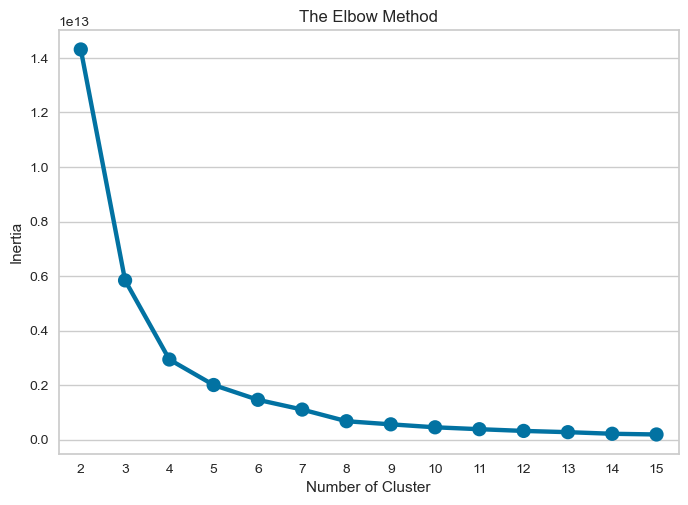

In [24]:
# Check results of elbow method

plt.title('The Elbow Method')
plt.xlabel('Number of Cluster')
plt.ylabel('Inertia')
sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))
plt.show()

In [25]:
# Locate the knee or elbow
cost_kneed = KneeLocator(x = K , y = list(wcss.values()) , S = 1.0 , curve = 'convex' , direction = 'decreasing' , online = True)
suggested_cluster = cost_kneed.elbow
print('Elbow at k = {} clusters'.format(suggested_cluster))

Elbow at k = 4 clusters


### Mathematical Method

C:\Users\MANCY036\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\MANCY036\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\MANCY036\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\MANCY036\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_c

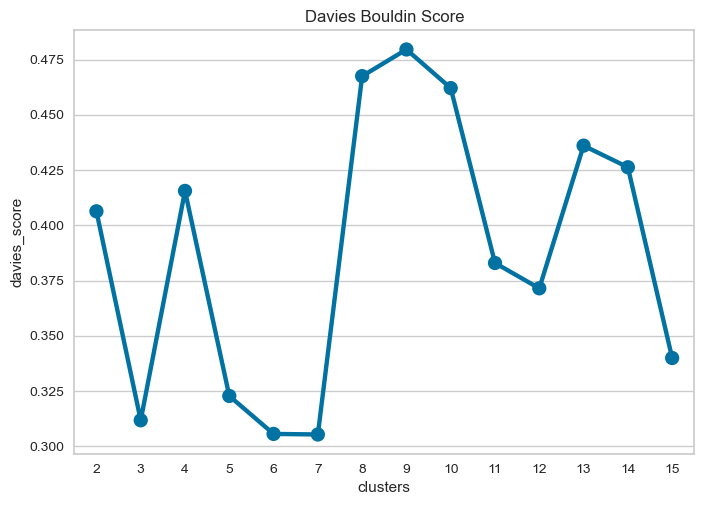

In [26]:
# Create plot for Davies-Bouldin score

plt.title('Davies Bouldin Score')
plt.xlabel('clusters')
plt.ylabel('davies_score')
sns.pointplot(x=list(davies_score.keys()), y=list(davies_score.values()))
plt.show()

C:\Users\MANCY036\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\MANCY036\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\MANCY036\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\MANCY036\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_c

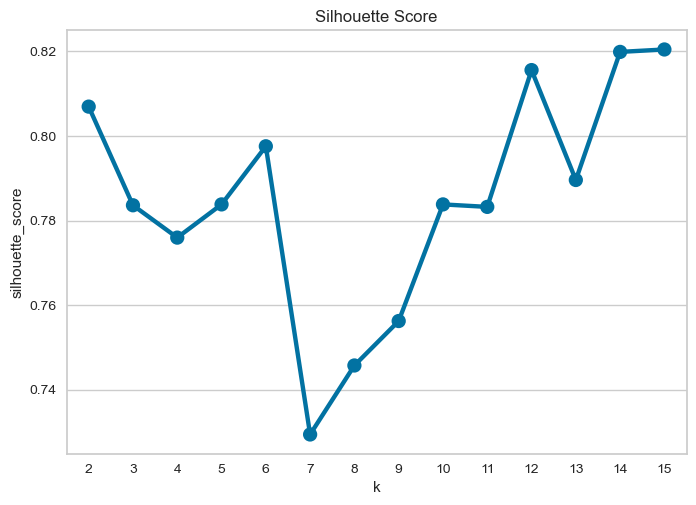

In [27]:
# Create plot for silhouette score

plt.title('Silhouette Score')
plt.xlabel('k')
plt.ylabel('silhouette_score')
sns.pointplot(x=list(ssc.keys()), y=list(ssc.values()))
plt.show()

In [28]:
# Create function for silhouette plot

def silhouette_plot(X , n_list):
    silhouette_scores = []
    for k in tqdm(n_list, desc='Progress'):
        #Instantiate model in k clusters
        model = KMeans(n_clusters = k, random_state=42, n_init=10)
        #Instantiate Visualizer model of with k clusters
        visualizer = SilhouetteVisualizer(model)
        #Fit data to the model
        visualizer.fit(X)
        #Draw data
        visualizer.poof()
        #Append score
        silhouette_scores.append([visualizer.silhouette_score_ , k])
    return silhouette_scores

In [29]:
# # Create silhouette plot

# k_cluster_test = [4, 5, 6]

# silhouette_plot(price_series_df , k_cluster_test)

## Clustering with chosen k

In [30]:
# Number of clusters (you can choose an appropriate value for your case)
n_clusters = 4

# Initialize K-means model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the model to the data
kmeans.fit(price_series)

# Get cluster labels
cluster_labels = kmeans.labels_
cluster_labels = cluster_labels + 1

C:\Users\MANCY036\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [31]:
# Declare your own custom palette with 7 colors
custom_palette = ["#227c9d", "#48cfae", "#4fc0e8", "#fe6d73", "#ffcb77", "#ff66c4"]

# Use the custom palette with only the first 5 colors
cluster_palette = sns.color_palette(custom_palette[:n_clusters])

### Snake plot

C:\Users\MANCY036\AppData\Local\Temp\ipykernel_8660\58466227.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='variable', y='value', hue='Cluster_Labels', data=df_melted, marker='o', ci=None, palette=cluster_palette)
C:\Users\MANCY036\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\MANCY036\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\MANCY036\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDt

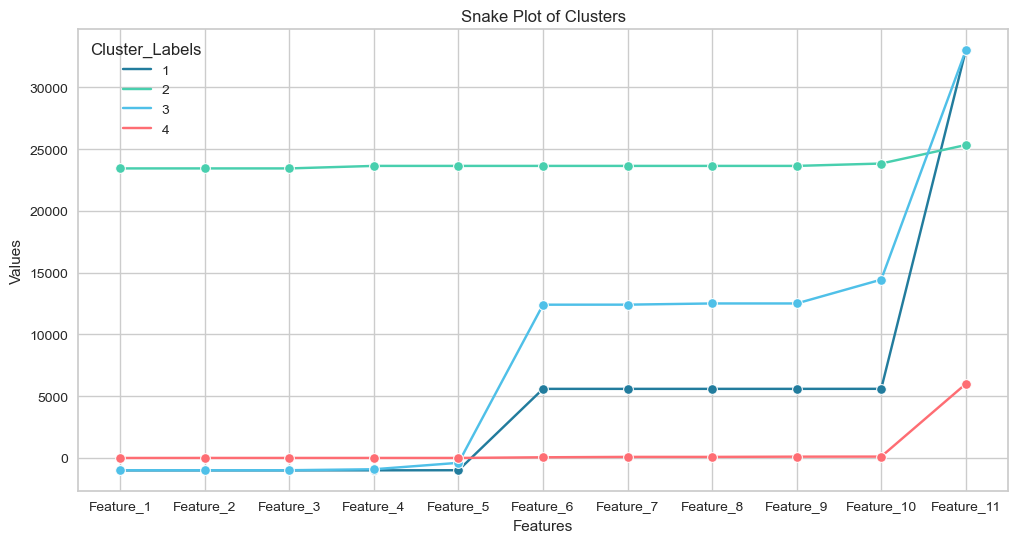

In [32]:
price_series_df['Cluster_Labels'] = cluster_labels

# Melt the DataFrame for the snake plot
df_melted = pd.melt(price_series_df, id_vars='Cluster_Labels', value_vars=price_series_df.columns[:-1])

# Create a snake plot using seaborn with specified color palette
plt.figure(figsize=(12, 6))
sns.lineplot(x='variable', y='value', hue='Cluster_Labels', data=df_melted, marker='o', ci=None, palette=cluster_palette)
plt.title('Snake Plot of Clusters')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

### TSNE graph

In [33]:
# # Initialise TSNE
# model = TSNE(random_state=1)
# transformed = model.fit_transform(price_series_df)

# # Plot t-SNE
# plt.title('Flattened Graph of {} Clusters'.format(n_clusters))
# sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")

### Count plot

C:\Users\MANCY036\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\MANCY036\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\MANCY036\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\MANCY036\Anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

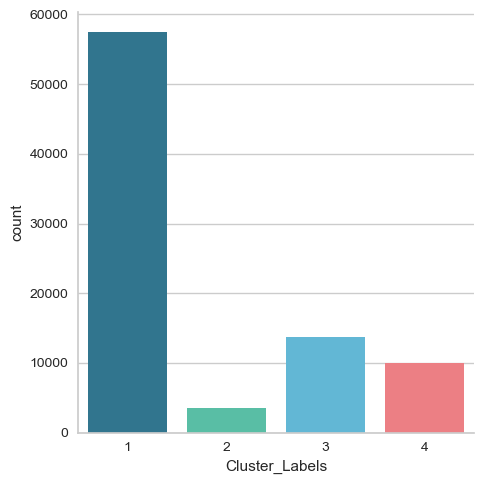

In [34]:
sns.catplot(
    data=price_series_df,
    x="Cluster_Labels",
    kind="count",
    palette=cluster_palette
)
plt.show()

## Stepwise Clustering

In [35]:
# # Define the quantity step
# quantity_step = 0.1

# # Define the range of quantities from 0 to 1 with the specified step
# quantities = np.arange(0, 1.1, quantity_step)

# # Extract the price columns
# price_columns = [f'Feature_{i}' for i in range(1, 12)]

# # Group by cluster labels
# grouped_clusters = price_series_df.groupby('Cluster_Labels')

# # Plot stepwise curves for each cluster
# for cluster, group in tqdm(grouped_clusters):
#     # Select the first 10000 curves or all if less than 10000
#     group = group.head(10000) if len(group) >= 10000 else group
    
#     # Plot stepwise curves
#     for index, row in group.iterrows():
#         prices = row[price_columns]
#         plt.step(quantities, prices, where='pre', color=f'C{cluster}', alpha=0.1, label=f'Cluster {cluster}')

# # Customize the plot
# plt.xlabel('Quantity')
# plt.ylabel('Price')
# #plt.legend(title='Clusters')
# plt.title('Stepwise Curves of Prices for Each Cluster')
# plt.show()


## Time Distribution Attempt

### Create a separate time distribution dataframe

In [36]:
time_distribution = df_2022.copy()

In [37]:
time_distribution.reset_index(drop=True, inplace=True)
time_distribution.head()

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,...,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
0,02/06/2022 07:15:00 PM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339
1,02/06/2022 07:20:00 PM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339
2,02/06/2022 08:50:00 PM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339
3,02/06/2022 08:55:00 PM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339
4,02/06/2022 09:00:00 PM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339,0.95339


In [38]:
time_distribution = time_distribution[['run_time', 'price1']]
time_distribution.head()

,run_time,price1
0,02/06/2022 07:15:00 PM,0.0
1,02/06/2022 07:20:00 PM,0.0
2,02/06/2022 08:50:00 PM,0.0
3,02/06/2022 08:55:00 PM,0.0
4,02/06/2022 09:00:00 PM,0.0


In [39]:
# Assuming df is your DataFrame
split_values = time_distribution['run_time'].str.split(' ', n=1, expand=True)
time_distribution['date'] = split_values[0]
time_distribution['time'] = split_values[1].fillna('12:00:00 AM')
time_distribution.head()

,run_time,price1,date,time
0,02/06/2022 07:15:00 PM,0.0,02/06/2022,07:15:00 PM
1,02/06/2022 07:20:00 PM,0.0,02/06/2022,07:20:00 PM
2,02/06/2022 08:50:00 PM,0.0,02/06/2022,08:50:00 PM
3,02/06/2022 08:55:00 PM,0.0,02/06/2022,08:55:00 PM
4,02/06/2022 09:00:00 PM,0.0,02/06/2022,09:00:00 PM


In [40]:
time_distribution = time_distribution.drop(columns = ['run_time', 'price1'])
time_distribution.head()

,date,time
0,02/06/2022,07:15:00 PM
1,02/06/2022,07:20:00 PM
2,02/06/2022,08:50:00 PM
3,02/06/2022,08:55:00 PM
4,02/06/2022,09:00:00 PM


In [41]:
time_distribution['cluster_labels'] = cluster_labels
time_distribution.head()

,date,time,cluster_labels
0,02/06/2022,07:15:00 PM,1
1,02/06/2022,07:20:00 PM,1
2,02/06/2022,08:50:00 PM,1
3,02/06/2022,08:55:00 PM,1
4,02/06/2022,09:00:00 PM,1


In [42]:
#time_distribution['date'] = pd.to_datetime(time_distribution['date'])
#-- didn't push through with converting the date column to datetime kasi for some reason nawawala yung ibang months (see above block)

time_distribution['time'] = pd.to_datetime(time_distribution['time'], format='%I:%M:%S %p')
time_distribution['time'] = time_distribution['time'].dt.time

time_distribution.head()

,date,time,cluster_labels
0,02/06/2022,19:15:00,1
1,02/06/2022,19:20:00,1
2,02/06/2022,20:50:00,1
3,02/06/2022,20:55:00,1
4,02/06/2022,21:00:00,1


In [43]:
time_distribution['time'].value_counts()

time
18:20:00    325
20:50:00    301
20:55:00    301
21:00:00    301
21:05:00    301
           ... 
09:25:00    286
09:55:00    286
10:40:00    286
10:30:00    286
10:50:00    285
Name: count, Length: 288, dtype: int64

In [44]:
time_distribution['date'] = pd.to_datetime(time_distribution['date'])
time_distribution['date'].value_counts()

date
2022-12-20    318
2022-07-07    288
2022-09-28    288
2022-09-26    288
2022-09-25    288
             ... 
2022-02-11    119
2022-03-19    107
2022-06-08     72
2022-09-16     60
2022-02-06     22
Name: count, Length: 303, dtype: int64

In [45]:
time_distribution['month_year'] = time_distribution['date'].dt.to_period('M')
time_distribution['month_year'].value_counts()

month_year
2022-12    8958
2022-05    8814
2022-10    8795
2022-07    8752
2022-03    8581
2022-11    8533
2022-04    8353
2022-06    8227
2022-02    5956
2022-08    5740
2022-09    3943
Freq: M, Name: count, dtype: int64

In [46]:
# Convert time into number of minutes since 0:00:00
time_distribution['time'] = time_distribution['time'].astype(str)
time_distribution['time'] = pd.to_datetime(time_distribution['time'], format='%H:%M:%S').dt.time
time_distribution['time_minutes'] = time_distribution['time'].apply(lambda x: x.hour * 60 + x.minute)

C:\Users\MANCY036\AppData\Local\Temp\ipykernel_8660\2955260713.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


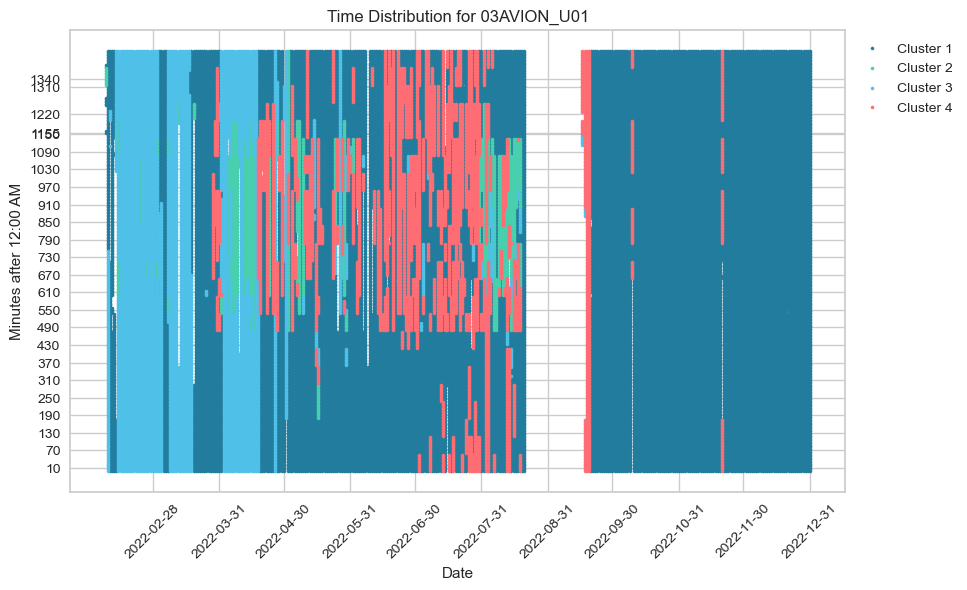

In [47]:
# Plot scatter plot with specified color palette
plt.figure(figsize=(10, 6))

unique_cluster_labels = time_distribution['cluster_labels'].unique()

for cluster_labels in unique_cluster_labels:
    cluster_data = time_distribution[time_distribution['cluster_labels'] == cluster_labels]
    
    # Adjust cluster_labels indexing to start from 0
    cluster_labels -= 1
    
    plt.scatter(
        cluster_data['date'],
        cluster_data['time_minutes'],
        label=f'Cluster {cluster_labels + 1}',  # Adjust label display
        s=5,
        c=cluster_palette[cluster_labels % len(cluster_palette)]
    )

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Minutes after 12:00 AM')
plt.title('Time Distribution for 03AVION_U01') # remember to change powerplant name

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

x_ticks = time_distribution['month_year'].unique()  
y_ticks = time_distribution['time_minutes'].unique()[::12]  
plt.xticks(x_ticks, rotation=45)
plt.yticks(y_ticks)

# Show the plot
plt.show()

In [48]:
# Generate a range of expected dates
expected_dates = pd.date_range(start='2022-01-01', end='2022-12-31')

# Find missing dates by comparing the expected dates with the actual dates
missing_dates = expected_dates[~expected_dates.isin(time_distribution['date'].unique())]

# Print the missing dates
print("Missing dates:", missing_dates)

Missing dates: DatetimeIndex(['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10', '2022-01-11', '2022-01-12',
               '2022-01-13', '2022-01-14', '2022-01-15', '2022-01-16',
               '2022-01-17', '2022-01-18', '2022-01-19', '2022-01-20',
               '2022-01-21', '2022-01-22', '2022-01-23', '2022-01-24',
               '2022-01-25', '2022-01-26', '2022-01-27', '2022-01-28',
               '2022-01-29', '2022-01-30', '2022-01-31', '2022-02-01',
               '2022-02-02', '2022-02-03', '2022-02-04', '2022-02-05',
               '2022-08-21', '2022-08-22', '2022-08-23', '2022-08-24',
               '2022-08-25', '2022-08-26', '2022-08-27', '2022-08-28',
               '2022-08-29', '2022-08-30', '2022-08-31', '2022-09-01',
               '2022-09-02', '2022-09-03', '2022-09-04', '2022-09-05',
               '2022-09-06', '2022-09-07', '2022-09-08', '2022